In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pickle
import os
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%matplotlib inline

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
with open('../Data/mHealth/mhealth_raw_data.pickle', 'rb') as f:
    df = pickle.load(f)

<AxesSubplot:>

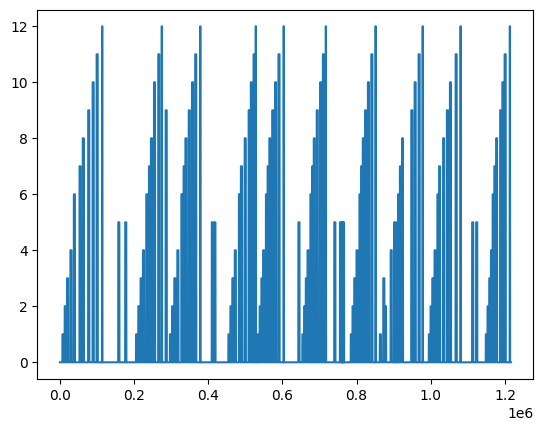

In [133]:
df['Activity'].plot()

In [134]:
from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [135]:
df

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
154060,-0.68636,-5.2902,4.64530,0.13544,-0.83114,-0.13163,-8.4230,-6.6402,2.98050,-0.93922,0.090349,0.219830,0,subject1
936066,1.00030,-7.7902,-6.74410,-0.26531,-0.14447,-1.09820,2.2046,-7.5497,4.02880,-0.21961,-1.080100,0.303880,0,subject8
167106,1.53220,-9.5966,-0.25618,-0.27273,-0.75985,0.63654,-2.5898,-8.5217,3.83430,-0.88431,-0.848050,0.331900,0,subject2
493889,1.78090,-8.5942,-3.97440,-0.41002,-0.55535,-0.78389,-1.0049,-6.8588,2.11540,-0.35686,-0.854210,-0.415950,0,subject4
355024,-0.34940,-9.5201,1.45800,-0.68275,-0.77861,-0.24558,-1.4178,-9.5157,1.43050,-0.12353,-0.967150,-0.497840,0,subject3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213641,-2.48730,-19.2330,3.46140,0.61967,-0.33771,-0.82711,-8.2348,-4.9652,2.48090,-0.43725,-1.018500,0.079741,12,subject10
1213642,-21.59100,-19.4370,-6.04190,0.61967,-0.33771,-0.82711,-21.3180,-10.2130,3.65600,-0.43725,-1.018500,0.079741,12,subject10
1213643,7.54330,-19.2450,-2.66800,0.61967,-0.33771,-0.82711,-21.2970,-18.7050,4.46060,-0.43725,-1.018500,0.079741,12,subject10
1213644,3.01420,-19.3340,-7.70740,0.71058,-0.27017,-0.75442,-21.1380,-18.6980,1.15880,-0.42549,-1.037000,0.084052,12,subject10


<AxesSubplot:>

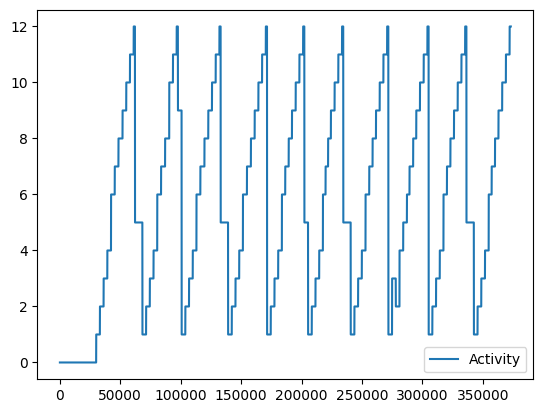

In [136]:
df[['Activity']].reset_index(drop=True).plot()

In [137]:
#Dropping feature have data outside 98% confidence interval
df1 = df.copy()
for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [95]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [138]:
print(df1.shape)
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

(310929, 14)


((246501, 14), (64428, 14))

In [166]:
df1[['subject']]

,subject
154060,subject1
936066,subject8
167106,subject2
493889,subject4
355024,subject3
...,...
1213636,subject10
1213637,subject10
1213640,subject10
1213641,subject10


In [98]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246501, 12), (246501,), (64428, 12), (64428,))

In [99]:
from scipy import stats

#function to create time series datset for seuence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1) 

## 0:100, 100:200 ...
## 0, 50, 100, ...


In [100]:
X_train_copy ,y_train_copy = create_dataset(X_train, y_train, 100, step=50)
X_train_copy.shape, y_train_copy.shape

((4929, 100, 12), (4929, 1))

In [68]:
X_train.values[50]

array([ 0.83059, -5.2852 , -0.79762, -0.25788, -0.5591 , -1.0138 ,
        3.4328 , -9.672  ,  9.7976 , -0.18627, -0.76797,  0.89224])

In [63]:
X_train_copy[1]

array([[  0.83059 ,  -5.2852  ,  -0.79762 , ...,  -0.18627 ,  -0.76797 ,
          0.89224 ],
       [  2.0891  ,  -9.5404  ,   1.4085  , ...,  -0.18627 ,   0.030801,
          1.1228  ],
       [  0.35037 ,  -8.0943  ,   2.453   , ...,  -0.74902 ,   0.23819 ,
          0.51724 ],
       ...,
       [-11.356   ,  -8.9798  ,  -8.8751  , ...,  -0.38235 ,  -0.6037  ,
         -0.58405 ],
       [  1.9896  , -10.318   ,  -0.13143 , ...,  -0.59412 ,   0.17248 ,
          1.0108  ],
       [ -0.055774,  -9.4624  ,   1.2867  , ...,  -0.2     ,  -0.79877 ,
          0.80819 ]])

In [101]:
X_test_copy,y_test_copy = create_dataset(X_test, y_test, 100, step=50)
X_test_copy.shape, y_test_copy.shape

((1287, 100, 12), (1287, 1))

In [55]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

In [102]:
model

Net(
  (conv1): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [81]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=100, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        
        self.max_pool = nn.MaxPool1d(kernel_size=2)
        
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=13)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.max_pool(x)
        
        x = x.permute(0, 2, 1) # Permute to match LSTM input shape
        x, _ = self.lstm(x)
        x = x[:, -1, :] # Only take the last output of the LSTM
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

In [104]:
model = Net().to(DEVICE)

In [83]:
model

Net(
  (conv1): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [105]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train1 = torch.from_numpy(X_train_copy).float().to(DEVICE)
y_train1 = torch.from_numpy(y_train_copy).long().to(DEVICE)

X_test1 = torch.from_numpy(X_test_copy).float().to(DEVICE)
y_test1 = torch.from_numpy(y_test_copy).long().to(DEVICE)

X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

(torch.Size([4929, 100, 12]),
 torch.Size([4929, 1]),
 torch.Size([1287, 100, 12]),
 torch.Size([1287, 1]))

In [75]:
X_train1

tensor([[[ -0.6864,  -5.2902,   4.6453,  ...,  -0.9392,   0.0903,   0.2198],
         [  1.0003,  -7.7902,  -6.7441,  ...,  -0.2196,  -1.0801,   0.3039],
         [  1.5322,  -9.5966,  -0.2562,  ...,  -0.8843,  -0.8480,   0.3319],
         ...,
         [  3.6543,  -9.0272,  -0.7377,  ...,  -0.0902,  -0.8727,  -0.6703],
         [  0.9086,  -9.5871,   1.6860,  ...,  -0.6882,  -0.8275,   0.0905],
         [  0.3465,  -7.6891,  -0.5893,  ...,  -0.1765,  -1.0267,  -0.3944]],

        [[  0.8306,  -5.2852,  -0.7976,  ...,  -0.1863,  -0.7680,   0.8922],
         [  2.0891,  -9.5404,   1.4085,  ...,  -0.1863,   0.0308,   1.1228],
         [  0.3504,  -8.0943,   2.4530,  ...,  -0.7490,   0.2382,   0.5172],
         ...,
         [-11.3560,  -8.9798,  -8.8751,  ...,  -0.3823,  -0.6037,  -0.5840],
         [  1.9896, -10.3180,  -0.1314,  ...,  -0.5941,   0.1725,   1.0108],
         [ -0.0558,  -9.4624,   1.2867,  ...,  -0.2000,  -0.7988,   0.8082]],

        [[  0.1517,  -9.7090,   1.3807,  ...

  4%|▍         | 4/100 [00:09<02:46,  1.73s/it]

Epoch: 0 Train Loss: 2.5651 Train Acc: 0.1343 Test Acc: 0.1601
Epoch: 1 Train Loss: 2.5639 Train Acc: 0.1923 Test Acc: 0.1880
Epoch: 2 Train Loss: 2.5629 Train Acc: 0.1954 Test Acc: 0.1772
Epoch: 3 Train Loss: 2.5620 Train Acc: 0.2004 Test Acc: 0.1709
Epoch: 4 Train Loss: 2.5609 Train Acc: 0.2037 Test Acc: 0.1709


 11%|█         | 11/100 [00:09<00:37,  2.38it/s]

Epoch: 5 Train Loss: 2.5597 Train Acc: 0.2067 Test Acc: 0.1702
Epoch: 6 Train Loss: 2.5583 Train Acc: 0.2110 Test Acc: 0.2059
Epoch: 7 Train Loss: 2.5567 Train Acc: 0.2256 Test Acc: 0.2222
Epoch: 8 Train Loss: 2.5549 Train Acc: 0.2408 Test Acc: 0.2432
Epoch: 9 Train Loss: 2.5527 Train Acc: 0.2497 Test Acc: 0.2688
Epoch: 10 Train Loss: 2.5501 Train Acc: 0.2562 Test Acc: 0.2813
Epoch: 11 Train Loss: 2.5470 Train Acc: 0.2550 Test Acc: 0.2735
Epoch: 12 Train Loss: 2.5435 Train Acc: 0.2518 Test Acc: 0.2657


 19%|█▉        | 19/100 [00:09<00:13,  5.88it/s]

Epoch: 13 Train Loss: 2.5394 Train Acc: 0.2506 Test Acc: 0.2650
Epoch: 14 Train Loss: 2.5346 Train Acc: 0.2473 Test Acc: 0.2626
Epoch: 15 Train Loss: 2.5292 Train Acc: 0.2418 Test Acc: 0.2626
Epoch: 16 Train Loss: 2.5230 Train Acc: 0.2384 Test Acc: 0.2603
Epoch: 17 Train Loss: 2.5160 Train Acc: 0.2368 Test Acc: 0.2642
Epoch: 18 Train Loss: 2.5079 Train Acc: 0.2428 Test Acc: 0.2782
Epoch: 19 Train Loss: 2.4990 Train Acc: 0.2603 Test Acc: 0.2991
Epoch: 20 Train Loss: 2.4889 Train Acc: 0.2828 Test Acc: 0.3302


 27%|██▋       | 27/100 [00:09<00:06, 11.11it/s]

Epoch: 21 Train Loss: 2.4778 Train Acc: 0.3009 Test Acc: 0.3481
Epoch: 22 Train Loss: 2.4657 Train Acc: 0.3171 Test Acc: 0.3489
Epoch: 23 Train Loss: 2.4526 Train Acc: 0.3242 Test Acc: 0.3497
Epoch: 24 Train Loss: 2.4391 Train Acc: 0.3236 Test Acc: 0.3489
Epoch: 25 Train Loss: 2.4254 Train Acc: 0.3246 Test Acc: 0.3489
Epoch: 26 Train Loss: 2.4116 Train Acc: 0.3244 Test Acc: 0.3489
Epoch: 27 Train Loss: 2.3980 Train Acc: 0.3256 Test Acc: 0.3489
Epoch: 28 Train Loss: 2.3849 Train Acc: 0.3260 Test Acc: 0.3512


 35%|███▌      | 35/100 [00:09<00:03, 17.87it/s]

Epoch: 29 Train Loss: 2.3724 Train Acc: 0.3277 Test Acc: 0.3535
Epoch: 30 Train Loss: 2.3604 Train Acc: 0.3341 Test Acc: 0.3613
Epoch: 31 Train Loss: 2.3488 Train Acc: 0.3400 Test Acc: 0.3761
Epoch: 32 Train Loss: 2.3374 Train Acc: 0.3518 Test Acc: 0.3939
Epoch: 33 Train Loss: 2.3258 Train Acc: 0.3650 Test Acc: 0.4157
Epoch: 34 Train Loss: 2.3138 Train Acc: 0.3743 Test Acc: 0.4250
Epoch: 35 Train Loss: 2.3012 Train Acc: 0.3812 Test Acc: 0.4320
Epoch: 36 Train Loss: 2.2882 Train Acc: 0.3867 Test Acc: 0.4312


 43%|████▎     | 43/100 [00:10<00:02, 23.65it/s]

Epoch: 37 Train Loss: 2.2748 Train Acc: 0.3914 Test Acc: 0.4320
Epoch: 38 Train Loss: 2.2616 Train Acc: 0.4143 Test Acc: 0.4328
Epoch: 39 Train Loss: 2.2489 Train Acc: 0.3974 Test Acc: 0.4289
Epoch: 40 Train Loss: 2.2369 Train Acc: 0.4153 Test Acc: 0.4305
Epoch: 41 Train Loss: 2.2257 Train Acc: 0.4041 Test Acc: 0.4281
Epoch: 42 Train Loss: 2.2155 Train Acc: 0.3841 Test Acc: 0.4211
Epoch: 43 Train Loss: 2.2059 Train Acc: 0.3857 Test Acc: 0.4188


 51%|█████     | 51/100 [00:10<00:01, 28.70it/s]

Epoch: 44 Train Loss: 2.1965 Train Acc: 0.3743 Test Acc: 0.4157
Epoch: 45 Train Loss: 2.1870 Train Acc: 0.3725 Test Acc: 0.4126
Epoch: 46 Train Loss: 2.1764 Train Acc: 0.3901 Test Acc: 0.4118
Epoch: 47 Train Loss: 2.1652 Train Acc: 0.3812 Test Acc: 0.4009
Epoch: 48 Train Loss: 2.1533 Train Acc: 0.4045 Test Acc: 0.4367
Epoch: 49 Train Loss: 2.1414 Train Acc: 0.4208 Test Acc: 0.4545
Epoch: 50 Train Loss: 2.1289 Train Acc: 0.4299 Test Acc: 0.4468
Epoch: 51 Train Loss: 2.1176 Train Acc: 0.4175 Test Acc: 0.4584


 59%|█████▉    | 59/100 [00:10<00:01, 32.76it/s]

Epoch: 52 Train Loss: 2.1069 Train Acc: 0.5798 Test Acc: 0.5921
Epoch: 53 Train Loss: 2.0916 Train Acc: 0.4654 Test Acc: 0.4623
Epoch: 54 Train Loss: 2.0808 Train Acc: 0.5494 Test Acc: 0.5664
Epoch: 55 Train Loss: 2.0677 Train Acc: 0.6036 Test Acc: 0.6146
Epoch: 56 Train Loss: 2.0579 Train Acc: 0.5902 Test Acc: 0.6030
Epoch: 57 Train Loss: 2.0470 Train Acc: 0.5936 Test Acc: 0.6030
Epoch: 58 Train Loss: 2.0393 Train Acc: 0.6535 Test Acc: 0.6651
Epoch: 59 Train Loss: 2.0307 Train Acc: 0.6815 Test Acc: 0.6838


 67%|██████▋   | 67/100 [00:10<00:00, 35.10it/s]

Epoch: 60 Train Loss: 2.0231 Train Acc: 0.7042 Test Acc: 0.6993
Epoch: 61 Train Loss: 2.0143 Train Acc: 0.7194 Test Acc: 0.7148
Epoch: 62 Train Loss: 2.0065 Train Acc: 0.7403 Test Acc: 0.7420
Epoch: 63 Train Loss: 1.9970 Train Acc: 0.7492 Test Acc: 0.7444
Epoch: 64 Train Loss: 1.9878 Train Acc: 0.7630 Test Acc: 0.7444
Epoch: 65 Train Loss: 1.9785 Train Acc: 0.7653 Test Acc: 0.7451
Epoch: 66 Train Loss: 1.9688 Train Acc: 0.7533 Test Acc: 0.7436
Epoch: 67 Train Loss: 1.9600 Train Acc: 0.7523 Test Acc: 0.7630


 75%|███████▌  | 75/100 [00:11<00:00, 36.43it/s]

Epoch: 68 Train Loss: 1.9517 Train Acc: 0.7513 Test Acc: 0.7708
Epoch: 69 Train Loss: 1.9436 Train Acc: 0.7496 Test Acc: 0.7692
Epoch: 70 Train Loss: 1.9367 Train Acc: 0.7705 Test Acc: 0.7700
Epoch: 71 Train Loss: 1.9303 Train Acc: 0.7521 Test Acc: 0.7754
Epoch: 72 Train Loss: 1.9247 Train Acc: 0.7776 Test Acc: 0.7723
Epoch: 73 Train Loss: 1.9158 Train Acc: 0.7884 Test Acc: 0.7848
Epoch: 74 Train Loss: 1.9035 Train Acc: 0.8077 Test Acc: 0.7972
Epoch: 75 Train Loss: 1.8941 Train Acc: 0.8377 Test Acc: 0.8050


 83%|████████▎ | 83/100 [00:11<00:00, 37.07it/s]

Epoch: 76 Train Loss: 1.8829 Train Acc: 0.8387 Test Acc: 0.7941
Epoch: 77 Train Loss: 1.8723 Train Acc: 0.8407 Test Acc: 0.7941
Epoch: 78 Train Loss: 1.8657 Train Acc: 0.8426 Test Acc: 0.8026
Epoch: 79 Train Loss: 1.8610 Train Acc: 0.8525 Test Acc: 0.8112
Epoch: 80 Train Loss: 1.8558 Train Acc: 0.8535 Test Acc: 0.8213
Epoch: 81 Train Loss: 1.8521 Train Acc: 0.8545 Test Acc: 0.8267
Epoch: 82 Train Loss: 1.8499 Train Acc: 0.8555 Test Acc: 0.8306
Epoch: 83 Train Loss: 1.8483 Train Acc: 0.8564 Test Acc: 0.8298


 91%|█████████ | 91/100 [00:11<00:00, 37.33it/s]

Epoch: 84 Train Loss: 1.8469 Train Acc: 0.8560 Test Acc: 0.8322
Epoch: 85 Train Loss: 1.8454 Train Acc: 0.8562 Test Acc: 0.8306
Epoch: 86 Train Loss: 1.8438 Train Acc: 0.8564 Test Acc: 0.8314
Epoch: 87 Train Loss: 1.8424 Train Acc: 0.8568 Test Acc: 0.8329
Epoch: 88 Train Loss: 1.8411 Train Acc: 0.8572 Test Acc: 0.8368
Epoch: 89 Train Loss: 1.8399 Train Acc: 0.8576 Test Acc: 0.8407
Epoch: 90 Train Loss: 1.8389 Train Acc: 0.8576 Test Acc: 0.8438
Epoch: 91 Train Loss: 1.8379 Train Acc: 0.8578 Test Acc: 0.8399


100%|██████████| 100/100 [00:11<00:00,  8.53it/s]

Epoch: 92 Train Loss: 1.8371 Train Acc: 0.8578 Test Acc: 0.8353
Epoch: 93 Train Loss: 1.8363 Train Acc: 0.8580 Test Acc: 0.8337
Epoch: 94 Train Loss: 1.8356 Train Acc: 0.8580 Test Acc: 0.8337
Epoch: 95 Train Loss: 1.8350 Train Acc: 0.8580 Test Acc: 0.8353
Epoch: 96 Train Loss: 1.8345 Train Acc: 0.8582 Test Acc: 0.8361
Epoch: 97 Train Loss: 1.8341 Train Acc: 0.8582 Test Acc: 0.8337
Epoch: 98 Train Loss: 1.8337 Train Acc: 0.8582 Test Acc: 0.8345
Epoch: 99 Train Loss: 1.8333 Train Acc: 0.8584 Test Acc: 0.8353


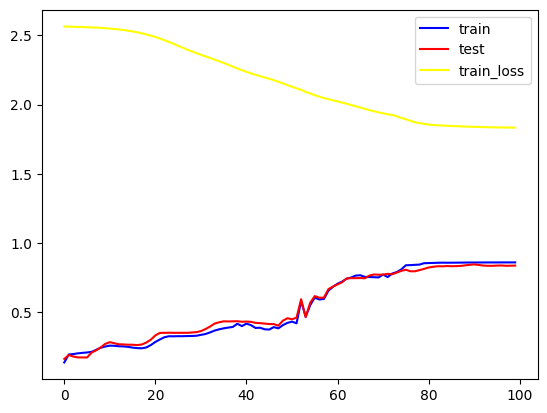

In [85]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def train(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs=10):
    train_acc = []
    test_acc = []
    train_loss =[]
    test_loss = []
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train.squeeze())
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_pred_test = model(X_test)
            train_acc.append(accuracy_score(y_train.cpu(), y_pred_train.cpu().argmax(1)))
            test_acc.append(accuracy_score(y_test.cpu(), y_pred_test.cpu().argmax(1)))
            train_loss.append(loss.item())
            print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Test Acc: {:.4f}'.format(epoch, loss.item(), train_acc[-1], test_acc[-1]))
    return train_acc, test_acc, train_loss


train_acc, test_acc, train_loss = train(model, X_train1, y_train1, X_test1, y_test1, optimizer, loss_fn, epochs=100)

plt.plot(train_acc, label='train', color = 'b')

plt.plot(test_acc, label='test', color = 'r')

plt.plot(train_loss, label = 'train_loss', color = 'yellow')

plt.legend()

plt.show()



In [108]:
X_train

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz
3,-1.50070,-13.84000,-7.79040,0.076067,-0.88368,0.282910,2.91280,-5.42950,2.05140,0.917650,-0.25051,0.67672
4,4.87730,-10.19100,-9.20040,0.371060,-0.92871,-0.239690,-1.46190,-17.41800,-3.79800,-0.060784,0.55647,1.02370
6,-0.78183,-10.43400,0.15798,0.235620,-0.75047,0.473480,-0.30675,-11.53300,0.73587,0.419610,-0.82752,0.62931
10,2.56990,-9.76950,0.27681,0.740260,-0.58912,0.131630,-4.19460,-11.20400,1.55440,0.156860,-0.91376,0.72414
13,1.08440,-9.62480,1.87340,0.319110,-0.60225,0.634580,-1.76200,-9.25180,2.81870,-0.074510,-0.65092,0.96983
...,...,...,...,...,...,...,...,...,...,...,...,...
373184,6.25990,0.85677,7.45960,0.552880,0.45591,0.143420,-3.77980,4.85040,8.04460,0.372550,0.26489,0.93103
373185,2.71240,-1.63480,-11.00300,0.070501,-0.57036,0.734770,-1.45910,-2.87400,2.59590,-0.237250,-0.25257,1.06030
373187,6.48060,-10.52500,5.90310,0.602970,-0.56848,-0.754420,-1.56790,-10.20700,4.33340,0.711760,-0.58316,-0.15302
373189,1.82920,-7.66660,-2.30250,0.241190,-0.77298,0.149310,-3.09420,-8.19130,7.87170,0.600000,-0.50308,1.03660


  3%|▎         | 3/100 [00:00<00:04, 20.44it/s]

Epoch: 0 Train Loss: 2.5659 Train Acc: 0.0952 Test Acc: 0.0878
Epoch: 1 Train Loss: 2.5642 Train Acc: 0.1298 Test Acc: 0.1158
Epoch: 2 Train Loss: 2.5624 Train Acc: 0.1309 Test Acc: 0.1204
Epoch: 3 Train Loss: 2.5605 Train Acc: 0.1718 Test Acc: 0.1274
Epoch: 4 Train Loss: 2.5582 Train Acc: 0.2092 Test Acc: 0.1608


 10%|█         | 10/100 [00:00<00:03, 29.83it/s]

Epoch: 5 Train Loss: 2.5555 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 6 Train Loss: 2.5521 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 7 Train Loss: 2.5480 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 8 Train Loss: 2.5432 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 9 Train Loss: 2.5378 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 10 Train Loss: 2.5316 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 11 Train Loss: 2.5247 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 12 Train Loss: 2.5174 Train Acc: 0.2094 Test Acc: 0.1624


 18%|█▊        | 18/100 [00:00<00:02, 34.22it/s]

Epoch: 13 Train Loss: 2.5098 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 14 Train Loss: 2.5021 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 15 Train Loss: 2.4948 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 16 Train Loss: 2.4879 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 17 Train Loss: 2.4820 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 18 Train Loss: 2.4772 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 19 Train Loss: 2.4737 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 20 Train Loss: 2.4714 Train Acc: 0.2094 Test Acc: 0.1624


 26%|██▌       | 26/100 [00:00<00:02, 35.69it/s]

Epoch: 21 Train Loss: 2.4700 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 22 Train Loss: 2.4690 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 23 Train Loss: 2.4681 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 24 Train Loss: 2.4672 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 25 Train Loss: 2.4660 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 26 Train Loss: 2.4646 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 27 Train Loss: 2.4631 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 28 Train Loss: 2.4617 Train Acc: 0.2094 Test Acc: 0.1624


 34%|███▍      | 34/100 [00:01<00:01, 36.19it/s]

Epoch: 29 Train Loss: 2.4610 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 30 Train Loss: 2.4610 Train Acc: 0.1903 Test Acc: 0.1601
Epoch: 31 Train Loss: 2.4616 Train Acc: 0.1889 Test Acc: 0.1570
Epoch: 32 Train Loss: 2.4623 Train Acc: 0.1889 Test Acc: 0.1570
Epoch: 33 Train Loss: 2.4625 Train Acc: 0.1889 Test Acc: 0.1570
Epoch: 34 Train Loss: 2.4621 Train Acc: 0.1889 Test Acc: 0.1570
Epoch: 35 Train Loss: 2.4614 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 36 Train Loss: 2.4607 Train Acc: 0.2094 Test Acc: 0.1624


 42%|████▏     | 42/100 [00:01<00:01, 36.70it/s]

Epoch: 37 Train Loss: 2.4603 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 38 Train Loss: 2.4603 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 39 Train Loss: 2.4605 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 40 Train Loss: 2.4609 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 41 Train Loss: 2.4610 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 42 Train Loss: 2.4610 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 43 Train Loss: 2.4608 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 44 Train Loss: 2.4605 Train Acc: 0.2094 Test Acc: 0.1624


 50%|█████     | 50/100 [00:01<00:01, 37.41it/s]

Epoch: 45 Train Loss: 2.4602 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 46 Train Loss: 2.4601 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 47 Train Loss: 2.4602 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 48 Train Loss: 2.4603 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 49 Train Loss: 2.4604 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 50 Train Loss: 2.4605 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 51 Train Loss: 2.4604 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 52 Train Loss: 2.4602 Train Acc: 0.2094 Test Acc: 0.1624


 58%|█████▊    | 58/100 [00:01<00:01, 37.40it/s]

Epoch: 53 Train Loss: 2.4601 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 54 Train Loss: 2.4600 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 55 Train Loss: 2.4601 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 56 Train Loss: 2.4601 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 57 Train Loss: 2.4602 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 58 Train Loss: 2.4601 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 59 Train Loss: 2.4601 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 60 Train Loss: 2.4600 Train Acc: 0.2094 Test Acc: 0.1624


 66%|██████▌   | 66/100 [00:01<00:00, 37.65it/s]

Epoch: 61 Train Loss: 2.4599 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 62 Train Loss: 2.4598 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 63 Train Loss: 2.4597 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 64 Train Loss: 2.4596 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 65 Train Loss: 2.4596 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 66 Train Loss: 2.4594 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 67 Train Loss: 2.4592 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 68 Train Loss: 2.4590 Train Acc: 0.2094 Test Acc: 0.1624


 74%|███████▍  | 74/100 [00:02<00:00, 37.51it/s]

Epoch: 69 Train Loss: 2.4587 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 70 Train Loss: 2.4584 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 71 Train Loss: 2.4581 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 72 Train Loss: 2.4578 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 73 Train Loss: 2.4574 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 74 Train Loss: 2.4570 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 75 Train Loss: 2.4564 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 76 Train Loss: 2.4559 Train Acc: 0.2094 Test Acc: 0.1624


 82%|████████▏ | 82/100 [00:02<00:00, 37.69it/s]

Epoch: 77 Train Loss: 2.4553 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 78 Train Loss: 2.4547 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 79 Train Loss: 2.4540 Train Acc: 0.2094 Test Acc: 0.1624
Epoch: 80 Train Loss: 2.4533 Train Acc: 0.2142 Test Acc: 0.1639
Epoch: 81 Train Loss: 2.4525 Train Acc: 0.2144 Test Acc: 0.1647
Epoch: 82 Train Loss: 2.4517 Train Acc: 0.2185 Test Acc: 0.1671
Epoch: 83 Train Loss: 2.4507 Train Acc: 0.2293 Test Acc: 0.1740
Epoch: 84 Train Loss: 2.4496 Train Acc: 0.2467 Test Acc: 0.1888


 90%|█████████ | 90/100 [00:02<00:00, 37.64it/s]

Epoch: 85 Train Loss: 2.4485 Train Acc: 0.2855 Test Acc: 0.1841
Epoch: 86 Train Loss: 2.4472 Train Acc: 0.3051 Test Acc: 0.1888
Epoch: 87 Train Loss: 2.4459 Train Acc: 0.3076 Test Acc: 0.1849
Epoch: 88 Train Loss: 2.4444 Train Acc: 0.2962 Test Acc: 0.1826
Epoch: 89 Train Loss: 2.4427 Train Acc: 0.2997 Test Acc: 0.1849
Epoch: 90 Train Loss: 2.4408 Train Acc: 0.2804 Test Acc: 0.1803
Epoch: 91 Train Loss: 2.4387 Train Acc: 0.2850 Test Acc: 0.1818
Epoch: 92 Train Loss: 2.4362 Train Acc: 0.2812 Test Acc: 0.1826


100%|██████████| 100/100 [00:02<00:00, 36.16it/s]

Epoch: 93 Train Loss: 2.4335 Train Acc: 0.2790 Test Acc: 0.1787
Epoch: 94 Train Loss: 2.4305 Train Acc: 0.2781 Test Acc: 0.1810
Epoch: 95 Train Loss: 2.4273 Train Acc: 0.2615 Test Acc: 0.1772
Epoch: 96 Train Loss: 2.4240 Train Acc: 0.2899 Test Acc: 0.1865
Epoch: 97 Train Loss: 2.4207 Train Acc: 0.2374 Test Acc: 0.1678
Epoch: 98 Train Loss: 2.4176 Train Acc: 0.2934 Test Acc: 0.1888
Epoch: 99 Train Loss: 2.4130 Train Acc: 0.2995 Test Acc: 0.1896


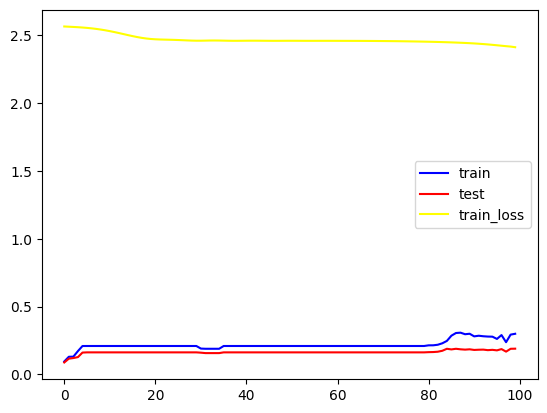

In [106]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def train(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs=10):
    train_acc = []
    test_acc = []
    train_loss =[]
    test_loss = []
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train.squeeze())
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_pred_test = model(X_test)
            train_acc.append(accuracy_score(y_train.cpu(), y_pred_train.cpu().argmax(1)))
            test_acc.append(accuracy_score(y_test.cpu(), y_pred_test.cpu().argmax(1)))
            train_loss.append(loss.item())
            print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Test Acc: {:.4f}'.format(epoch, loss.item(), train_acc[-1], test_acc[-1]))
    return train_acc, test_acc, train_loss


train_acc, test_acc, train_loss = train(model, X_train1, y_train1, X_test1, y_test1, optimizer, loss_fn, epochs=100)

plt.plot(train_acc, label='train', color = 'b')

plt.plot(test_acc, label='test', color = 'r')

plt.plot(train_loss, label = 'train_loss', color = 'yellow')

plt.legend()

plt.show()



In [2]:
with open('../Data/mHealth_subject10.log', 'r') as f:
    data = f.readlines()

In [35]:
def toPickle(path, name):
    with open(path, 'r') as f:
        data = f.readlines()
    for i in range(len(data)):
        data[i] = data[i].split('\t')
        data[i][-1] = data[i][-1].strip('\n')

    for i in range(len(data)):
        data[i] = [float(x) for x in data[i]]
    
    cols = ['xc_ACC', 'yc_ACC', 'zc_ACC', 'ecg1', 'ecg2', 'xla_ACC', 'yla_ACC', 'zla_ACC', 'xla_GYR', 'yla_GYR', 'zla_GYR', 'xla_MAG', 'yla_MAG', 'zla_MAG', 'xrla_ACC',
        'yrla_ACC','zrla_ACC','xrla_GYR','yrla_GYR','zrla_GYR','xrla_MAG','yrla_MAG','zrla_MAG', 'label']
    
    mHealth_subject = pd.DataFrame(data, columns=cols)

    print(mHealth_subject['label'].value_counts())

    with open('../Data/mHealth/' + name + '.pickle', 'wb') as f:
        pickle.dump(mHealth_subject, f)

    return mHealth_subject

In [47]:
a = toPickle('../Data/mHealth/mHealth_subject9.log', 'mHealth_subject9')

0.0     100814
1.0       3072
2.0       3072
3.0       3072
4.0       3072
9.0       3072
10.0      3072
11.0      3072
5.0       3072
8.0       2969
6.0       2867
7.0       2867
12.0      1075
Name: label, dtype: int64


In [124]:
with open('../Data/mHealth/mHealth_subject5.pickle', 'rb') as f:
    data = pickle.load(f)

<AxesSubplot:>

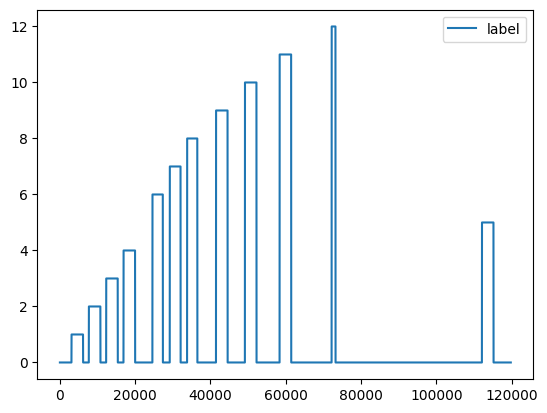

In [125]:
data[['label']].plot()

In [22]:
import copy

data_copy = copy.deepcopy(data)

In [23]:
for i in range(len(data)):
    data_copy[i] = data_copy[i].split('\t')
    data_copy[i][-1] = data_copy[i][-1].strip('\n')

In [24]:
for i in range(len(data_copy)):
    data_copy[i] = [float(x) for x in data_copy[i]]

In [30]:
cols = ['xc_ACC', 'yc_ACC', 'zc_ACC', 'ecg1', 'ecg2', 'xla_ACC', 'yla_ACC', 'zla_ACC', 'xla_GYR', 'yla_GYR', 'zla_GYR', 'xla_MAG', 'yla_MAG', 'zla_MAG', 'xrla_ACC',
        'yrla_ACC','zrla_ACC','xrla_GYR','yrla_GYR','zrla_GYR','xrla_MAG','yrla_MAG','zrla_MAG', 'label']

In [31]:
mHealth_subject10 = pd.DataFrame(data_copy, columns=cols)

In [33]:
mHealth_subject10['label'].value_counts()

0.0     64614
5.0      3072
1.0      3072
2.0      3072
3.0      3072
4.0      3072
9.0      3072
10.0     3072
11.0     3072
8.0      2867
7.0      2765
6.0      2458
12.0     1024
Name: label, dtype: int64

In [29]:
cols = ['xc_ACC', 'yc_ACC', 'zc_ACC', 'ecg1', 'ecg2', 'xla_ACC', 'yla_ACC', 'zla_ACC', 'xla_GYR', 'yla_GYR', 'zla_GYR', 'xla_MAG', 'yla_MAG', 'zla_MAG', 'xrla_ACC',
        'yrla_ACC','zrla_ACC','xrla_GYR','yrla_GYR','zrla_GYR','xrla_MAG','yrla_MAG','zrla_MAG', 'label']

In [1]:
modal_chest = ['xc_ACC', 'yc_ACC', 'zc_ACC', 'ecg1', 'ecg2']
modal_left_angle = ['xla_ACC', 'yla_ACC', 'zla_ACC', 'xla_GYR', 'yla_GYR', 'zla_GYR', 'xla_MAG', 'yla_MAG', 'zla_MAG']
modal_right_lower_arm = ['xrla_ACC', 'yrla_ACC','zrla_ACC','xrla_GYR','yrla_GYR','zrla_GYR','xrla_MAG','yrla_MAG','zrla_MAG']


In [30]:
with open('../Data/mHealth/mHealth_subject1.pickle', 'rb') as f:
    data = pickle.load(f)
data['label'].value_counts()

0.0     126106
8.0       3379
1.0       3072
2.0       3072
3.0       3072
4.0       3072
6.0       3072
7.0       3072
9.0       3072
10.0      3072
11.0      3072
5.0       3072
12.0      1075
Name: label, dtype: int64

In [32]:
np.random.randint(0, 100, 10)

array([40, 46, 94, 95, 30, 79, 90, 55, 24, 32])

In [43]:
data['label'].value_counts()

0.0     126106
8.0       3379
1.0       3072
2.0       3072
3.0       3072
4.0       3072
6.0       3072
7.0       3072
9.0       3072
10.0      3072
11.0      3072
5.0       3072
12.0      1075
Name: label, dtype: int64

In [46]:
result = pd.DataFrame([])
for i in range(1, 13):
    if i == 12:
        balanced = data.loc[data['label'] == i].reset_index(drop=True)
    else:
        balanced = data.loc[data['label'] == i].reset_index(drop=True).loc[np.random.randint(0, 3072, 1075)].reset_index(drop=True)

    result = pd.concat([result, balanced], axis=0)

In [50]:
shuf = result.sample(frac=1).reset_index(drop=True)

In [54]:
with open('../Data/mHealth/mHealth_balanced.pickle', 'wb') as f:
    pickle.dump(shuf, f)

In [55]:
with open('../Data/mHealth/mHealth_balanced.pickle', 'rb') as f:
    data = pickle.load(f)

In [57]:
data['label'].value_counts()

6.0     1075
11.0    1075
1.0     1075
7.0     1075
5.0     1075
12.0    1075
3.0     1075
4.0     1075
2.0     1075
9.0     1075
8.0     1075
10.0    1075
Name: label, dtype: int64

In [48]:
result = result.reset_index(drop=True)

In [41]:
balanced = data.loc[data['label'] == 0].reset_index(drop=True).loc[np.random.randint(0, 120000, 1075)].reset_index(drop=True)


In [42]:
balanced

,xc_ACC,yc_ACC,zc_ACC,ecg1,ecg2,xla_ACC,yla_ACC,zla_ACC,xla_GYR,yla_GYR,...,xrla_ACC,yrla_ACC,zrla_ACC,xrla_GYR,yrla_GYR,zrla_GYR,xrla_MAG,yrla_MAG,zrla_MAG,label
0,-8.5822,0.82613,-5.33620,0.083726,0.016745,0.83519,-6.5804,-0.61233,0.40260,-0.71670,...,-3.1347,-8.098100,9.18880,0.456860,-0.45585,1.12070,6.90430,8.199600,10.16400,0.0
1,-1.0691,-0.58708,1.07350,0.309790,0.234430,2.67580,-13.1660,-1.70440,-0.66605,-0.51595,...,-6.7746,-0.772570,1.74260,-0.631370,0.18686,-0.78664,-0.55111,-1.251400,19.49600,0.0
2,-9.5481,-0.37230,1.41910,-0.221870,-0.255360,2.07050,-9.5889,0.52043,0.56215,-0.69418,...,-3.8799,-9.491700,0.82750,0.233330,-0.99795,0.51724,3.05140,-0.062389,-3.18740,0.0
3,-8.7145,-0.63675,-3.62570,-0.012559,0.163270,2.57980,-9.4506,-2.48840,-0.58813,-0.70732,...,-3.5698,-9.830600,1.93560,0.321570,-0.99589,-0.21121,4.81490,50.614000,-33.62300,0.0
4,-9.7485,0.55521,0.38681,-0.079540,-0.711670,2.15950,-9.6617,0.16351,-0.20037,-0.84240,...,-2.2988,-9.176500,1.35370,0.105880,-0.98973,-0.39655,0.53495,-0.364570,0.37536,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,-8.7621,-1.29140,0.17851,0.012559,0.246990,0.22346,-10.3800,-4.36050,-0.40631,-0.61538,...,-1.3259,-8.915000,1.50220,-0.029412,-1.14370,-0.46983,7.59080,5.038300,21.40100,0.0
1071,-10.4290,1.23170,-1.27860,-1.084200,-0.293040,5.97840,-8.1895,-0.14136,-0.34694,-0.90994,...,-8.0121,-0.035851,1.41490,-0.845100,-0.66119,-0.20690,-53.77200,8.841700,267.79000,0.0
1072,-9.0401,2.50870,-3.34260,0.577710,0.904240,2.41800,-8.4097,-3.34420,0.14286,-0.88931,...,4.1319,-11.771000,1.85930,-0.456860,-0.76181,-0.48707,-4.36540,-41.565000,13.32500,0.0
1073,-8.4531,1.44290,0.79302,0.020931,0.355830,1.04890,-10.5910,-2.64410,0.74397,-0.42026,...,-6.2904,-6.893600,0.64491,-0.676470,-0.39014,0.77155,12.02700,17.750000,-64.19700,0.0


In [17]:
data.loc[data['label'] == 0]['xc_ACC'].describe()

count    64614.000000
mean        -8.874695
std          3.323434
min        -22.139000
25%         -9.900675
50%         -9.294050
75%         -7.430800
max         13.272000
Name: xc_ACC, dtype: float64

In [18]:
data.loc[data['label'] == 3]['xc_ACC'].describe()

count    3072.000000
mean       -1.971242
std         0.197143
min        -2.582600
25%        -2.106700
50%        -1.988400
75%        -1.847550
max        -0.925930
Name: xc_ACC, dtype: float64

In [19]:
data['label'].value_counts()

0.0     64614
5.0      3072
1.0      3072
2.0      3072
3.0      3072
4.0      3072
9.0      3072
10.0     3072
11.0     3072
8.0      2867
7.0      2765
6.0      2458
12.0     1024
Name: label, dtype: int64

,xc_ACC,yc_ACC,zc_ACC,ecg1,ecg2,xla_ACC,yla_ACC,zla_ACC,xla_GYR,yla_GYR,...,xrla_ACC,yrla_ACC,zrla_ACC,xrla_GYR,yrla_GYR,zrla_GYR,xrla_MAG,yrla_MAG,zrla_MAG,label
0,-9.4570,0.12269,2.5163,-0.062794,0.506540,-0.007531,-9.5752,0.89616,-0.47310,-0.68856,...,-3.46760,-9.5290,3.09650,-0.852940,-0.634500,0.24353,-8.95110,2.559700,-7.0638,6.0
1,-21.8200,-1.44610,12.6910,-0.895870,-1.728900,19.606000,-19.3380,-18.94800,0.71614,-0.62477,...,-20.80600,-7.3736,-15.35800,-0.925490,0.022587,0.60345,157.35000,7.599900,-117.1500,11.0
2,-9.8095,0.57741,1.1362,-0.087912,-0.142330,2.581100,-9.6585,0.49080,-0.21336,-0.88931,...,-3.07820,-9.1534,1.65690,-0.072549,-0.940450,-0.34483,0.35892,-0.014346,-1.0757,1.0
3,-9.3517,0.41577,3.6164,-0.142330,-0.280480,2.480100,-9.5274,0.72551,-0.35807,-0.80488,...,0.41776,9.0539,3.39020,-0.174510,1.043100,-0.22629,-1.77400,2.133700,-6.1940,7.0
4,-9.0360,2.30680,-1.3292,-0.025118,-0.133960,-0.773570,-8.5874,-3.29130,0.50649,-0.75610,...,-3.79490,-7.2376,0.24229,-0.505880,-0.542090,1.09480,-15.57600,-31.531000,-10.8270,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12895,-7.9340,-0.27121,-4.0455,-0.221870,0.066981,1.244100,-4.2712,-4.34700,0.41373,-0.72608,...,1.27740,-7.6503,5.97170,0.643140,-0.560570,1.03660,-6.23460,4.904000,-24.0000,9.0
12896,-14.4130,0.42798,1.3754,0.096285,0.196760,3.690200,-16.1100,2.90850,0.53618,-0.80863,...,-3.87470,-10.4600,1.97700,-0.582350,-0.636550,0.74353,-4.65750,-16.919000,9.4623,4.0
12897,-17.6880,3.59160,-15.2350,-0.523290,-1.339600,-6.180000,-16.0250,-4.43590,0.50093,-0.70919,...,-21.12300,-3.4009,-6.08670,-0.884310,0.199180,0.59483,-8.85120,12.549000,84.5350,12.0
12898,-8.0950,-0.80391,-3.4618,0.100470,-0.062794,-1.053400,-9.1817,-4.31340,0.51577,-0.58161,...,-1.77450,-4.7427,4.73160,0.658820,-0.556470,1.02590,2.37700,-13.651000,-19.6720,9.0
